## Doorlooptijd per incidentcategorie (Deelvraag 2)

In dit deel van het notebook wordt de doorlooptijd van incidenten geanalyseerd per incidentcategorie.
De focus ligt op:

- gemiddelde en maximale oplostijd;
- spreiding (standaarddeviatie);
- percentielen (P50, P80, P90, P95) als input voor een datagedreven SLA-model;
- het aandeel incidenten dat **langer dan 14 dagen** openstaat (bottlenecks).

**Setup & Imports**

In deze cel laden we de benodigde Python-libraries in voor analyse en visualisatie.

In [1]:
!pip install pandas numpy matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


**Visuele stijl instellen (Power BI look)**

De standaard Jupyter-stijl is donker en past niet bij de visuele stijl van Power BI.
Daarom gebruiken we in onderstaande configuratie een witte achtergrond, blauwe tinten
en duidelijke assen in dezelfde stijl als Power BI.


In [2]:
# Power BI-achtige kleuren (blauw als hoofdkleur, met wat accentkleuren)
powerbi_palette = ["#118DFF", "#12239E", "#E66C37", "#6B007B", "#E044A7", "#744EC2"]

# Globale seaborn/matplotlib stijl
plt.style.use("default")
sns.set_theme(
    style="whitegrid",      # lichte achtergrond + subtiele grid
    palette=powerbi_palette,
    font_scale=1.1
)

# Extra cosmetics: wit canvas en rustige as-/gridkleuren
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["axes.edgecolor"] = "#666666"
plt.rcParams["grid.color"] = "#DDDDDD"
plt.rcParams["axes.labelcolor"] = "#333333"
plt.rcParams["xtick.color"] = "#333333"
plt.rcParams["ytick.color"] = "#333333"

**Dataset inladen**

We lezen het incidentbestand in en controleren de kolommen.

In [3]:
DATA_PATH = "incidentdata_2019_clean.csv"

df = pd.read_csv(DATA_PATH)

print("Kolommen gevonden:")
print(df.columns)

df.head()

Kolommen gevonden:
Index(['incident nummer', 'Incident categorie', 'totale minuten open',
       'Prioriteit incident'],
      dtype='object')


,incident nummer,Incident categorie,totale minuten open,Prioriteit incident
0,1065298,2e lijns (Doorgezette incidenten),19902,E8
1,1124826,Hardware / Werkplekbeheer,133,E8
2,1156332,2e lijns (Doorgezette incidenten),1270,E8
3,1183663,Functioneel beheer,327156,E8
4,1183923,Functioneel beheer,327159,E8


**Basisschoonmaak en tijdsvariabelen**

_Opschonen van de dataset is al in Power BI uitgevoerd._

Hier maken we alleen de tijdvariabelen aan die nodig zijn voor analyse.

In [4]:
# Zorg dat tijdkolom numeriek is
df["totale minuten open"] = pd.to_numeric(df["totale minuten open"], errors="coerce")

# Direct clean kopiëren (de BI-opschoning bevat geen 0 of negatieve waarden meer)
df_clean = df.copy()

# Nieuwe tijdvariabelen berekenen
df_clean["uren"] = df_clean["totale minuten open"] / 60
df_clean["dagen"] = df_clean["totale minuten open"] / 1440

df_clean.head()

,incident nummer,Incident categorie,totale minuten open,Prioriteit incident,uren,dagen
0,1065298,2e lijns (Doorgezette incidenten),19902,E8,331.700000,13.820833
1,1124826,Hardware / Werkplekbeheer,133,E8,2.216667,0.092361
2,1156332,2e lijns (Doorgezette incidenten),1270,E8,21.166667,0.881944
3,1183663,Functioneel beheer,327156,E8,5452.600000,227.191667
4,1183923,Functioneel beheer,327159,E8,5452.650000,227.193750


**Statistieken per incidentcategorie**

_Hier berekenen we de belangrijkste statistieken die nodig zijn voor SLA-ontwerp:_
- Gemiddelde
- Mediaan
- Maximum
- Spreiding
- Standaard deviatie

### Statistieken per incidentcategorie

Onderstaande tabel toont per incidentcategorie het aantal incidenten, de gemiddelde doorlooptijd,
mediaan, maximale doorlooptijd en de standaarddeviatie. De doorlooptijd is omgerekend van minuten
naar uren en dagen.

- 1e en 2e lijns incidenten hebben een korte, stabiele doorlooptijd.
- 3e lijns incidenten en Functioneel beheer hebben duidelijk hogere gemiddelden en maxima.
- De standaarddeviatie is daar ook hoger, wat wijst op grote variatie in oplostijden.


In [5]:
stats = df_clean.groupby("Incident categorie")["totale minuten open"].agg(
    Aantal="count",
    Gemiddelde="mean",
    Mediaan="median",
    Maximum="max",
    Std="std"
).round(1)

# Omrekenen naar uren en dagen
stats["Gem (uren)"] = (stats["Gemiddelde"] / 60).round(1)
stats["Gem (dagen)"] = (stats["Gemiddelde"] / 1440).round(1)
stats["Max (dagen)"] = (stats["Maximum"] / 1440).round(1)

stats

,Aantal,Gemiddelde,Mediaan,Maximum,Std,Gem (uren),Gem (dagen),Max (dagen)
Incident categorie,,,,,,,,
1e lijns beheer (Helpdesk),819,718.0,7.0,74891,4484.5,12.0,0.5,52.0
2e lijns (Doorgezette incidenten),15651,1722.9,7.0,289361,12458.1,28.7,1.2,200.9
3e lijns (Technische incidenten),624,35577.4,20010.5,281940,44647.5,593.0,24.7,195.8
Functioneel beheer,4726,27783.5,10.0,331278,71912.1,463.1,19.3,230.1
Hardware / Werkplekbeheer,3220,3586.1,143.5,344146,14892.4,59.8,2.5,239.0
Telefonie / Communicatie,769,4689.1,127.0,226202,17285.1,78.2,3.3,157.1


### Gemiddelde doorlooptijd in dagen per categorie

De onderstaande staafgrafiek vat de gemiddelde doorlooptijd per incidentcategorie samen (in dagen).
Hierin is duidelijk te zien:

- 1e en 2e lijn lossen incidenten gemiddeld binnen één dag af.
- 3e lijn en Functioneel beheer hebben gemiddeld een veel langere doorlooptijd (enkele weken).
- Hardware en Telefonie zitten hier tussenin.

Deze verschillen laten zien dat incidentcategorieën inhoudelijk sterk van elkaar verschillen in
complexiteit en behandelduur. Dit is een belangrijk signaal dat één uniforme SLA niet realistisch is.

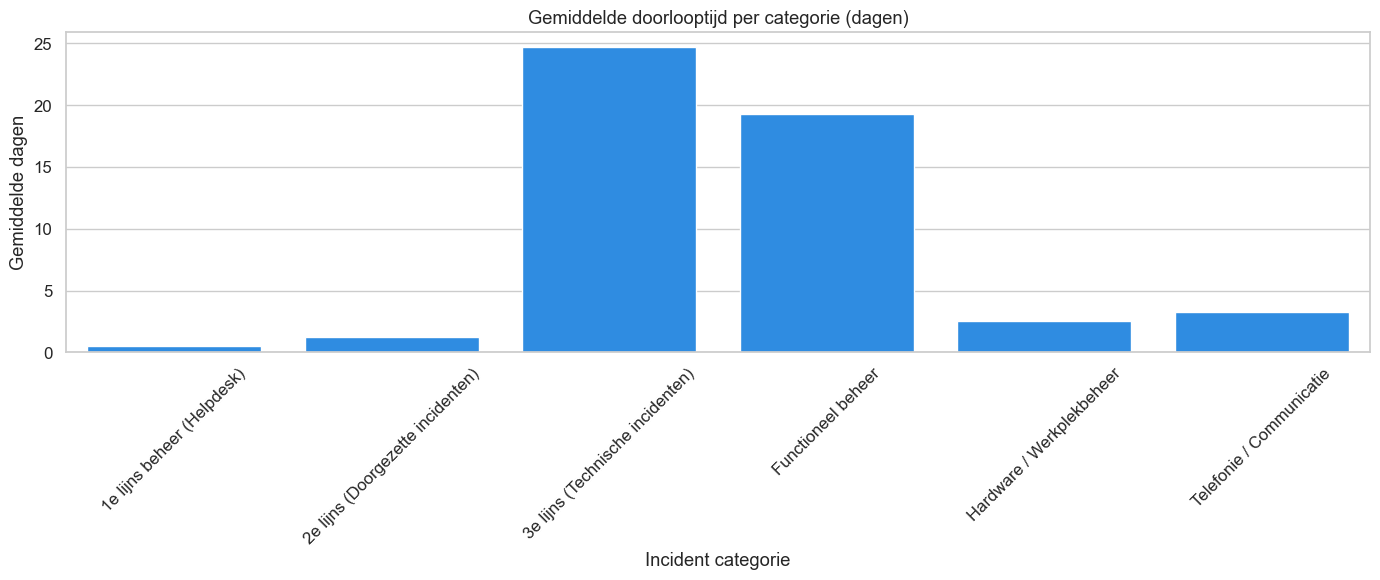

In [6]:
plt.figure(figsize=(14,6))
sns.barplot(
    data=stats.reset_index(),
    x="Incident categorie",
    y="Gem (dagen)"
)

plt.xticks(rotation=45)
plt.title("Gemiddelde doorlooptijd per categorie (dagen)")
plt.ylabel("Gemiddelde dagen")
plt.xlabel("Incident categorie")
plt.tight_layout()
plt.show()

### Percentielen als basis voor SLA-grenzen

Om realistische SLA-grenzen te kunnen bepalen zijn per incidentcategorie de percentielen P50, P80,
P90 en P95 berekend. Percentielen zijn minder gevoelig voor uitschieters dan gemiddelden en sluiten
beter aan op SLA-afspraken.

Interpretatie:

- **P50 (mediaan)**: helft van de incidenten is binnen deze tijd opgelost (normale case).
- **P80–P90**: realistische SLA-kandidaten (80–90% van de incidenten op tijd opgelost).
- **P95**: worst-case scenario, bruikbaar voor escalatieafspraken.

Uit de tabel blijkt dat:
- 1e en 2e lijn, percentielen hebben in minuten tot enkele dagen;
- 3e lijn en Functioneel beheer percentielen hebben die oplopen tot weken;
- Hardware en Telefonie hier tussenin zitten, met enkele extreme gevallen.


In [7]:
percentielen = df_clean.groupby("Incident categorie")["totale minuten open"].quantile(
    [0.5, 0.8, 0.9, 0.95]
).unstack()

# # Omrekenen naar uren
# percentielen = (percentielen / 60).round(0)

percentielen

,0.50,0.80,0.90,0.95
Incident categorie,,,,
1e lijns beheer (Helpdesk),7.0,48.4,150.4,1477.70
2e lijns (Doorgezette incidenten),7.0,68.0,1084.0,6873.00
3e lijns (Technische incidenten),20010.5,62666.4,96518.6,106810.40
Functioneel beheer,10.0,17156.0,96440.5,249097.75
Hardware / Werkplekbeheer,143.5,1739.0,8431.0,14475.25
Telefonie / Communicatie,127.0,3065.6,9009.4,20902.00


### Lange incidenten (>14 dagen) als bottleneck-indicator

Om de bottlenecks in de doorlooptijd te identificeren is gekeken naar incidenten die **langer dan
14 dagen** openstaan. Voor iedere incidentcategorie is berekend:

- het totaal aantal incidenten;
- het aantal incidenten dat >14 dagen openstaat;
- het percentage lange incidenten binnen de categorie;
- het aandeel van alle lange incidenten dat uit die categorie komt.

De grafiek toont het **aandeel van alle lange incidenten (>14 dagen)** per categorie. De tabel eronder
laat de exacte waarden zien.

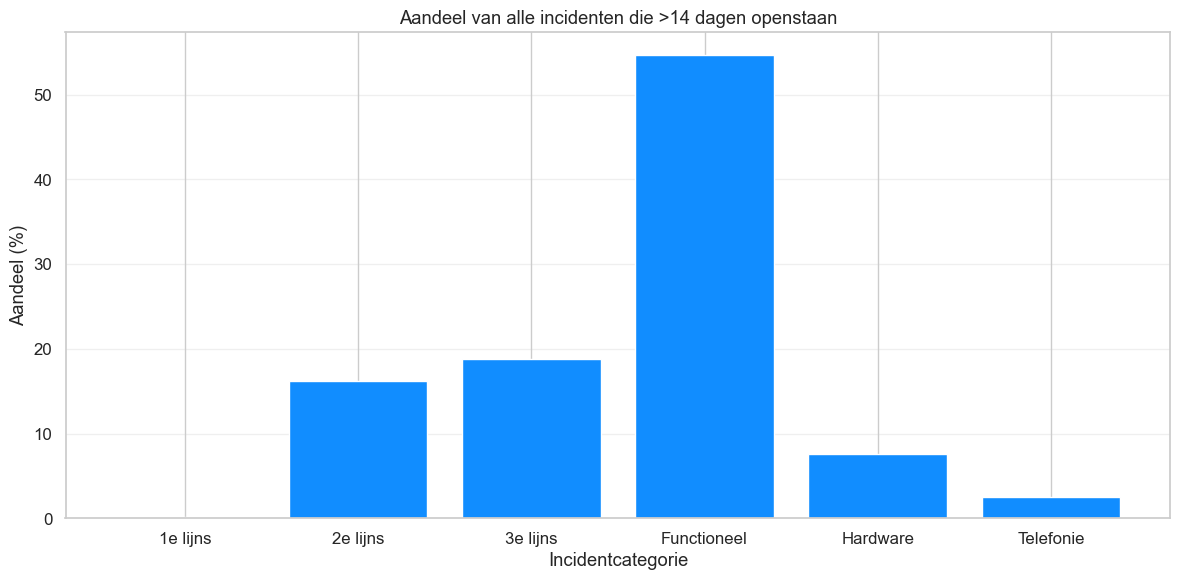

,totaal_incidenten,lange_incidenten,pct_lange_incidenten,aandeel_lange_totaal
Incident categorie,,,,
1e lijns beheer (Helpdesk),819,3,0.37,0.18
2e lijns (Doorgezette incidenten),15651,266,1.70,16.21
3e lijns (Technische incidenten),624,309,49.52,18.83
Functioneel beheer,4726,897,18.98,54.66
Hardware / Werkplekbeheer,3220,125,3.88,7.62
Telefonie / Communicatie,769,41,5.33,2.50


In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Instellingen ---
threshold_days = 14  # kies hier bijv. 7, 14 of 30 dagen
threshold_minutes = threshold_days * 1440

category_order = [
    "1e lijns beheer (Helpdesk)",
    "2e lijns (Doorgezette incidenten)",
    "3e lijns (Technische incidenten)",
    "Functioneel beheer",
    "Hardware / Werkplekbeheer",
    "Telefonie / Communicatie"
]

display_labels = {
    "1e lijns beheer (Helpdesk)": "1e lijns",
    "2e lijns (Doorgezette incidenten)": "2e lijns",
    "3e lijns (Technische incidenten)": "3e lijns",
    "Functioneel beheer": "Functioneel",
    "Hardware / Werkplekbeheer": "Hardware",
    "Telefonie / Communicatie": "Telefonie",
}

# --- Analyse ---
df_clean["is_long"] = df_clean["totale minuten open"] > threshold_minutes

agg = (
    df_clean.groupby("Incident categorie")
    .agg(
        totaal_incidenten=("totale minuten open", "count"),
        lange_incidenten=("is_long", "sum")
    )
    .reindex(category_order)
)

# Percentage binnen categorie
agg["pct_lange_incidenten"] = (agg["lange_incidenten"] / agg["totaal_incidenten"]) * 100

# Aandeel van alle lange incidenten
agg["aandeel_lange_totaal"] = (agg["lange_incidenten"] / agg["lange_incidenten"].sum()) * 100

# Afronden
agg["pct_lange_incidenten"] = agg["pct_lange_incidenten"].round(2)
agg["aandeel_lange_totaal"] = agg["aandeel_lange_totaal"].round(2)

# --- Plot ---
plt.figure(figsize=(12,6))
plt.bar(
    [display_labels.get(cat, cat) for cat in agg.index],
    agg["aandeel_lange_totaal"]
)

plt.title(f"Aandeel van alle incidenten die >{threshold_days} dagen openstaan")
plt.ylabel("Aandeel (%)")
plt.xlabel("Incidentcategorie")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

agg


## Samenvatting van de doorlooptijdanalyse

In dit notebook is de doorlooptijd per incidentcategorie geanalyseerd. Voor elke categorie zijn de
volgende statistieken berekend:

- Gemiddelde oplostijd (in minuten, uren en dagen)
- Mediaan
- Maximale oplostijd
- Spreiding (standaarddeviatie)
- Percentielen (P50, P80, P90, P95) als basis voor een datagedreven SLA-model
- Aandeel incidenten dat langer dan 14 dagen openstaat (>14d-analyse)

**Belangrijkste inzichten:**

- **1e en 2e lijn** lossen incidenten snel en voorspelbaar op; het percentage lange incidenten (>14 dagen)
  is hier verwaarloosbaar.
- **3e lijn** en **Functioneel beheer** hebben de langste doorlooptijden en de grootste spreiding; een
  groot deel van hun incidenten staat langer dan 14 dagen open.
- **Hardware** en **Telefonie** bevinden zich qua doorlooptijd tussen snelle (1e/2e lijn) en trage
  categorieën (3e lijn/Functioneel) in, met enkele uitschieters.

De >14d-analyse laat zien dat een groot deel van alle langdurig openstaande incidenten afkomstig is
uit 3e lijn en Functioneel beheer. Deze categorieën vormen daarmee de belangrijkste bottlenecks in
het oplosproces.

Omdat de doorlooptijdverdeling sterk verschilt per categorie, is één uniforme SLA niet realistisch.
De resultaten uit dit notebook vormen de basis voor Deelvraag 2 en maken het mogelijk om:

- realistische SLA-grenzen per categorie op percentielbasis te bepalen;
- categorieën met structureel lange doorlooptijden te identificeren;
- verschillen in complexiteit tussen teams te onderbouwen;
- bottlenecks (met name 3e lijn en Functioneel beheer) zichtbaar te maken.